In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from IPython.display import display

from disruption_survival_analysis.sweep_config import create_experiment_groups, get_experiments


from disruption_survival_analysis.plot_experiments import plot_auroc_timeslice_all_vs_horizon
from disruption_survival_analysis.plot_experiments import plot_false_alarm_rate_vs_threshold, plot_threshold_vs_false_alarm_rate, plot_auroc_timeslice_shot_avg_vs_horizon, plot_warning_time_vs_false_alarm_rate, plot_roc_curve, plot_warning_time_vs_threshold
from disruption_survival_analysis.plot_experiments import plot_risk_compare_models, plot_ettd_compare_models
from disruption_survival_analysis.plot_experiments import plot_disruptive_vs_non_disruptive_shot_durations

device = 'synthetic'
dataset_path = 'test'
#device = 'cmod'
#dataset_path = 'preliminary_dataset_no_ufo'

# models, alarms, metrics, and minimum warning times to use
models = ['rf', 'dsm']
alarms = ['hyst']
metrics = ['auroc', 'auwtc']
min_warning_times = [0.02, 0.1]

# Load models and create experiments
experiment_groups = create_experiment_groups(device, dataset_path, models, alarms, metrics, min_warning_times)

c:\Users\zkeith\proj\disruption-survival-analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for synthetic/test/rf_hyst_auroc_20ms.yaml
---
Loaded model from models/synthetic/test/rf_hyst_auroc_20ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for synthetic/test/rf_hyst_auroc_100ms.yaml
---
Loaded model from models/synthetic/test/rf_hyst_auroc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for synthetic/test/rf_hyst_auwtc_20ms.yaml
---
Loaded model from models/synthetic/test/rf_hyst_auwtc_20ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for synthetic/test/rf_hyst_auwtc_100ms.yaml
---
Loaded model from models/synthetic/test/rf_hyst_auwtc_100ms.pkl
---
Attempting to load hyperparameters from yaml file...
Loaded hyperparameters for synthetic/test/dsm_hyst_auroc_20ms.yaml
---
Loaded model from models/synthetic/test/dsm_hyst_auroc_20ms.pkl
---
Attempting to load hyperparameters from 

## Micro Average ROC AUC vs Horizon

See how the models perform at the individual timeslice level across the entire database.

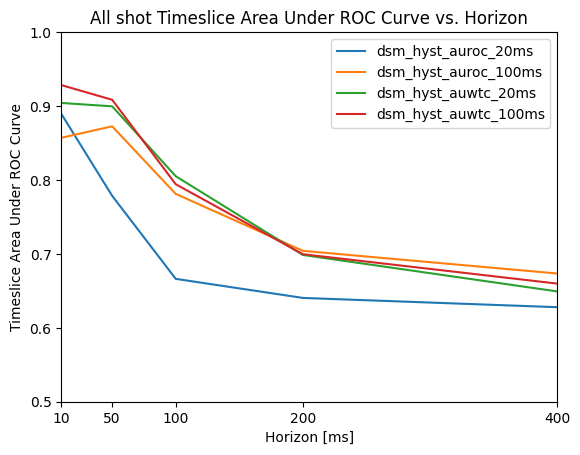

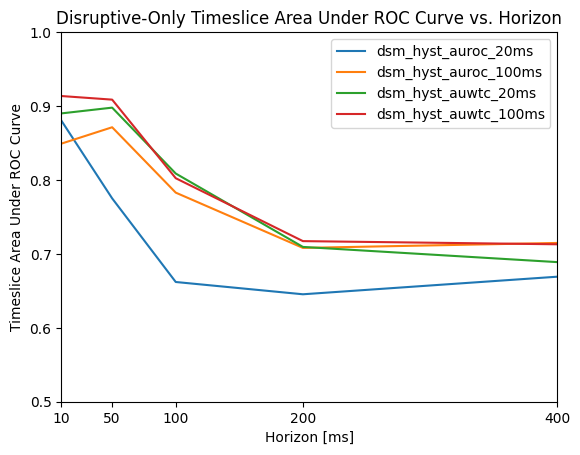

In [2]:
experiment_list = get_experiments(experiment_groups, ['dsm', 'hyst'])
plot_auroc_timeslice_all_vs_horizon(experiment_list, disrupt_only=False)
plot_auroc_timeslice_all_vs_horizon(experiment_list, disrupt_only=True)


## Table of Metrics:

In [3]:
required_warning_time = 0.1

result_data = []
for experiment in experiment_list:
    auroc = experiment.evaluate_metric('auroc', required_warning_time=required_warning_time)
    auwtc = experiment.evaluate_metric('auwtc', required_warning_time=required_warning_time)
    maxf1 = experiment.evaluate_metric('maxf1', required_warning_time=required_warning_time)
    tar, far, avg_warn, std_warn = experiment.max_f1_info(required_warning_time=required_warning_time)
    
    result_array = [experiment.name, auroc, auwtc*1000, maxf1, tar, far, avg_warn*1000, std_warn*1000]
    result_data.append(result_array)
    
result_df = pd.DataFrame(result_data, columns=['Experiment Name', 'AUROC', 'AUWTC', 'Max F1', 'TAR', 'FAR', 'Avg. Warn [ms]', 'Std. Warn [ms]'])
print(f"Model Performance when Reqired Warning Time is {required_warning_time*1000} ms")
display(result_df)

Model Performance when Reqired Warning Time is 100.0 ms


,Experiment Name,AUROC,AUWTC,Max F1,TAR,FAR,Avg. Warn [ms],Std. Warn [ms]
0,dsm_hyst_auroc_20ms,0.534046,20.865246,0.444444,0.4,0.064516,118.362459,154.093554
1,dsm_hyst_auroc_100ms,0.183871,29.016783,0.243902,1.0,1.000000,752.730353,167.544663
2,dsm_hyst_auwtc_20ms,0.214516,29.492407,0.285714,0.4,0.225806,28.628065,0.000000
3,dsm_hyst_auwtc_100ms,0.398925,21.399234,0.266667,0.8,0.677419,103.362459,147.080401


## ROC Curve

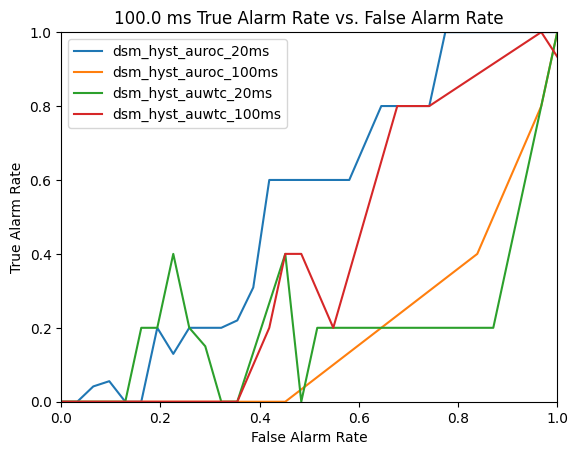

In [4]:
plot_roc_curve(experiment_list, required_warning_time=required_warning_time)

## Area Under Warning Time Curve



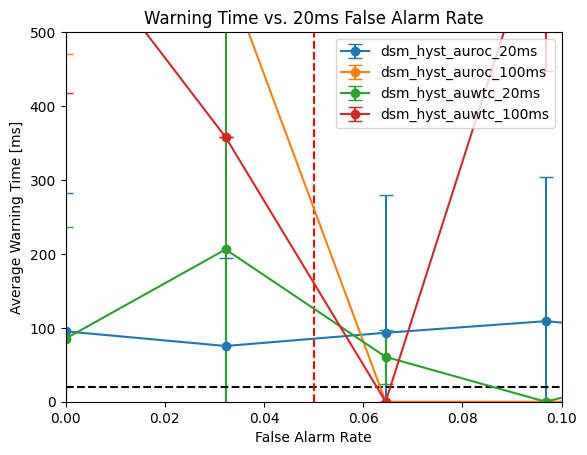

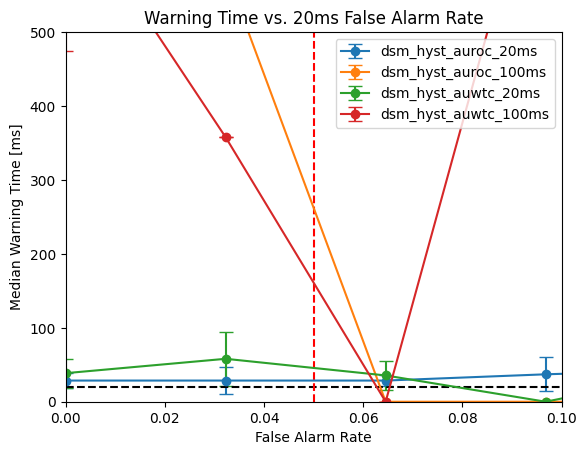

In [5]:
plot_warning_time_vs_false_alarm_rate(experiment_list, cutoff_far=0.05, method='average')
plot_warning_time_vs_false_alarm_rate(experiment_list, cutoff_far=0.05, method='median')

## Warning Time vs. Threshold

In [8]:
plot_warning_time_vs_threshold(experiment_list, cutoff_far=0.05, method='average')
plot_warning_time_vs_threshold(experiment_list, cutoff_far=0.05, method='median')

## False Positive Rate vs. Threshold

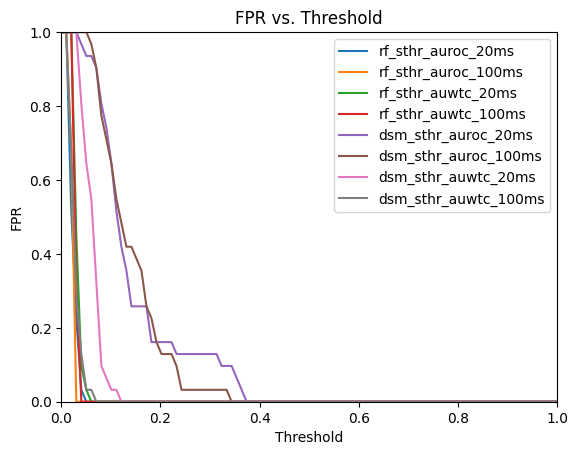

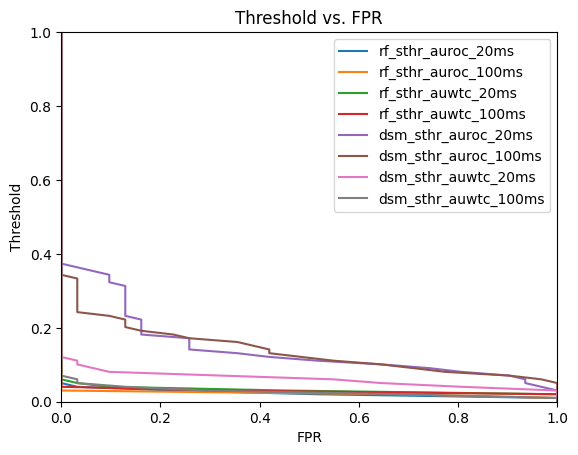

In [ ]:
plot_false_alarm_rate_vs_threshold(experiment_list, cutoff_far=0.05, method='average')
plot_threshold_vs_false_alarm_rate(experiment_list, cutoff_far=0.05, method='average')

## Model Output plotted over time

Dotted line is the hyperparameter horizon / class time. (How far before the disruption the model should start to 'see' it coming)

Solid line is required warning time.

c:\Users\zkeith\proj\disruption-survival-analysis\disruption_survival_analysis\plot_experiments.py:310: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


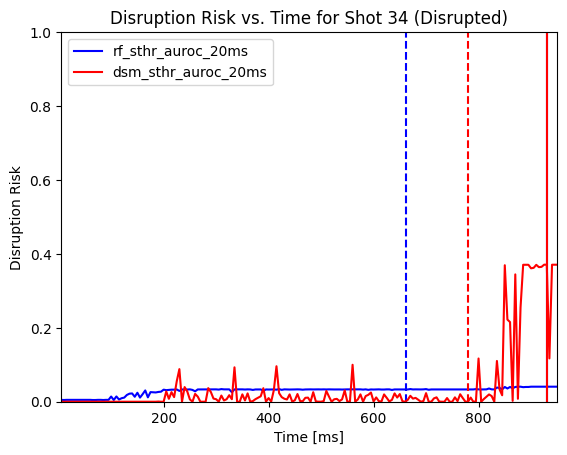

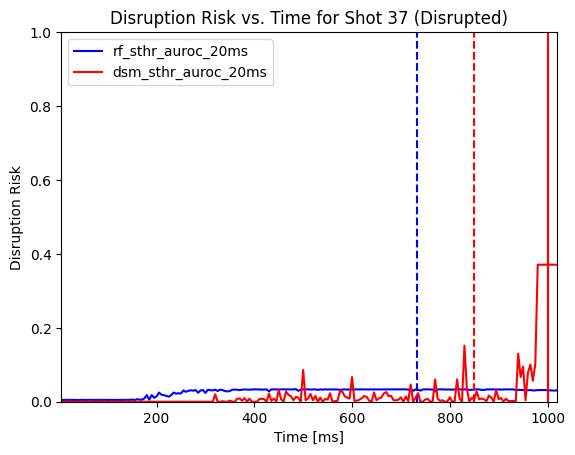

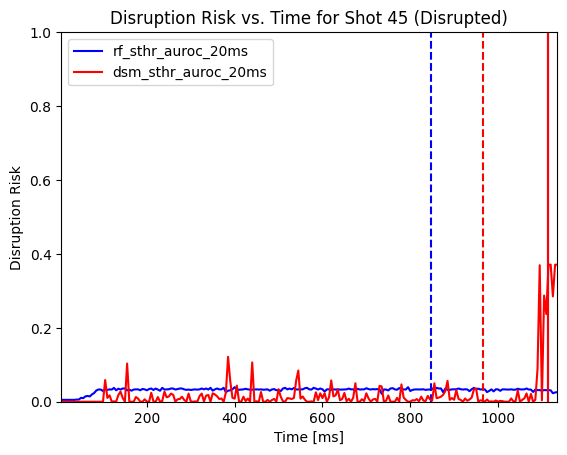

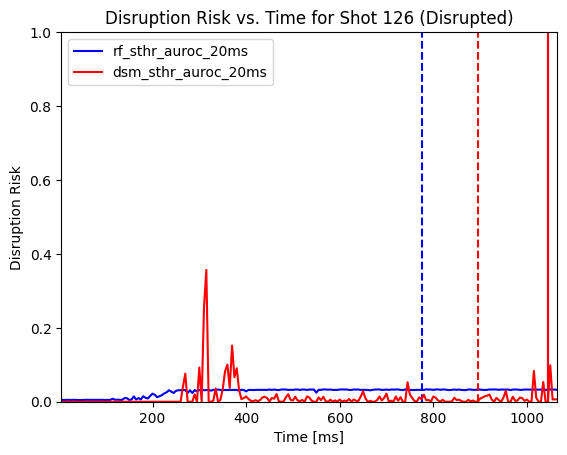

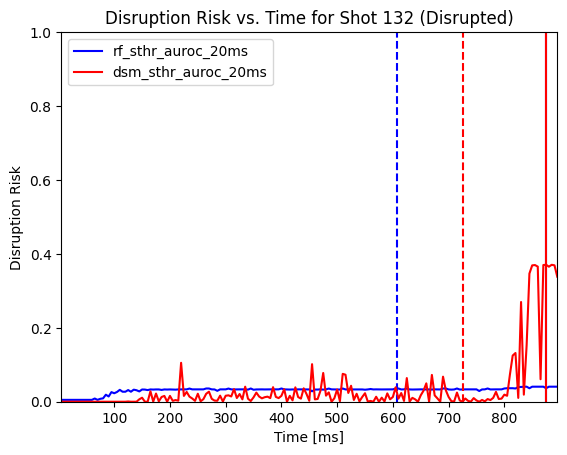

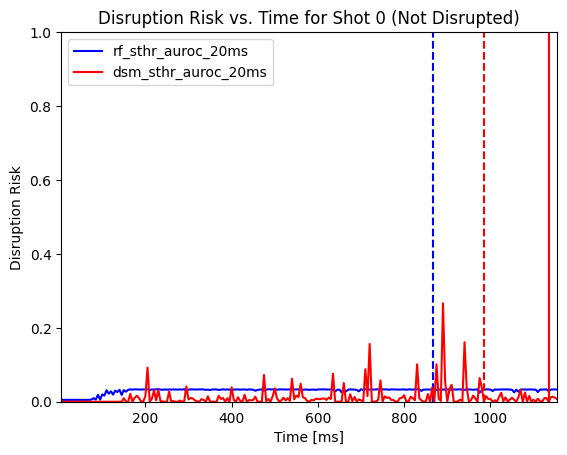

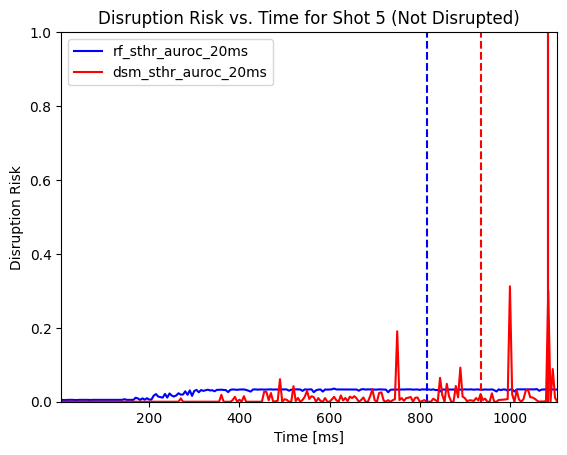

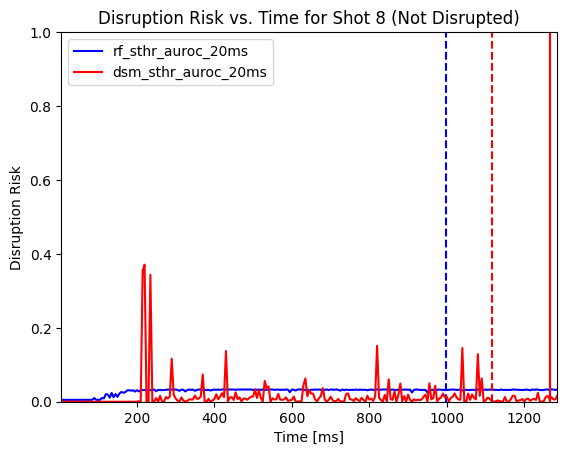

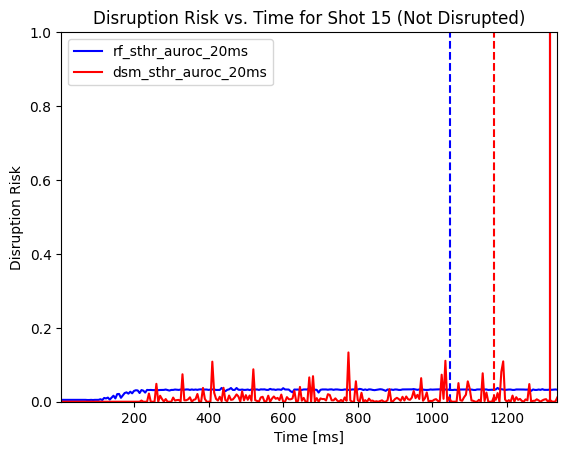

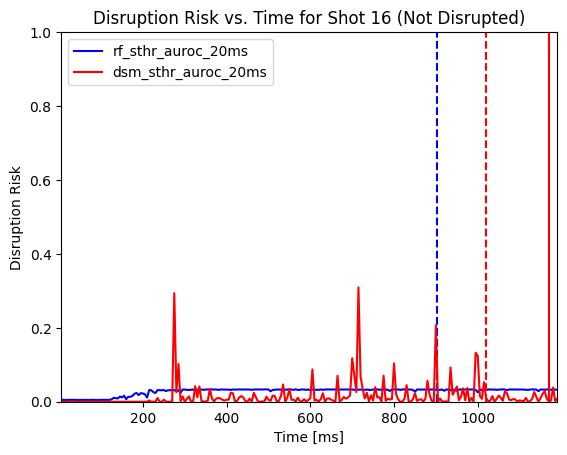

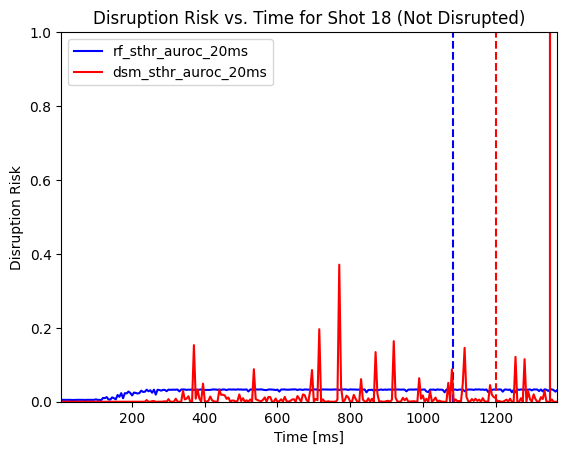

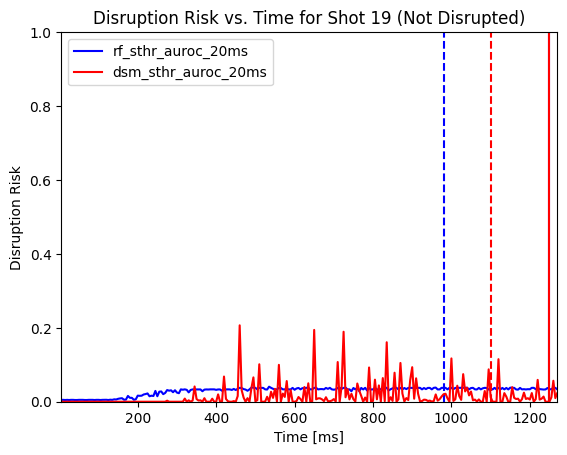

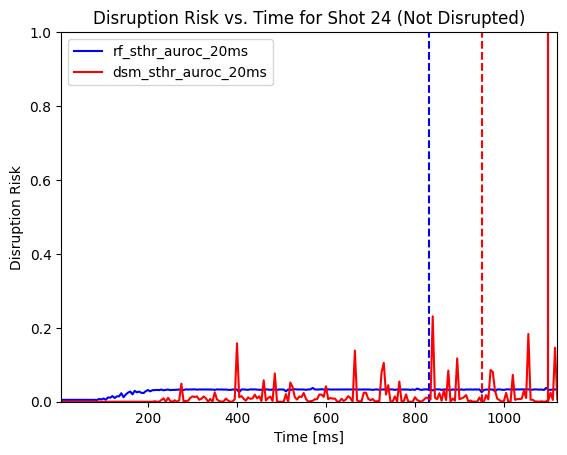

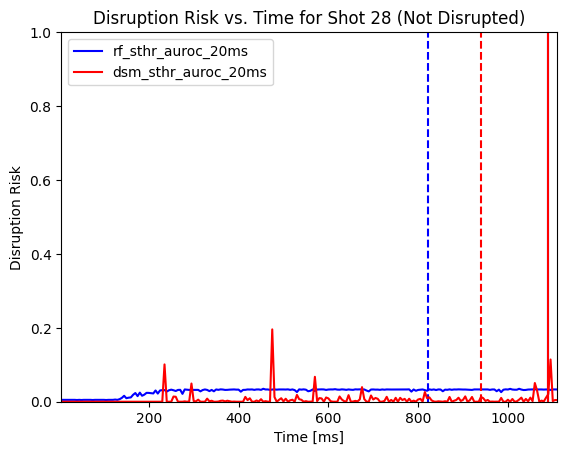

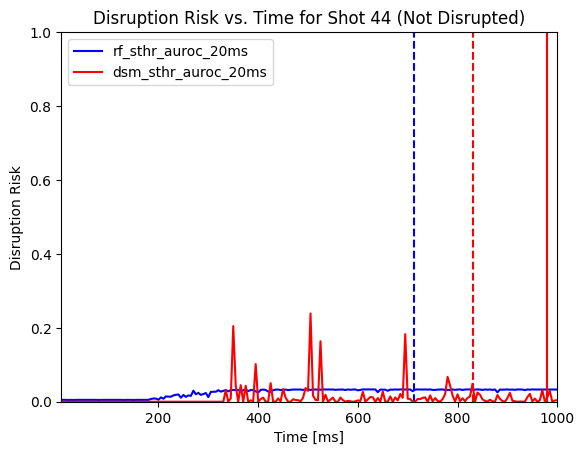

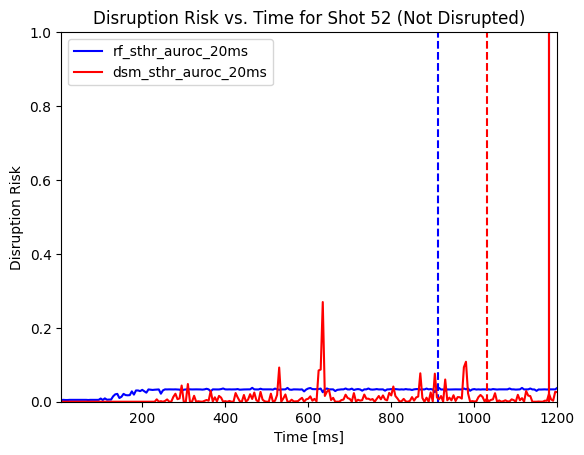

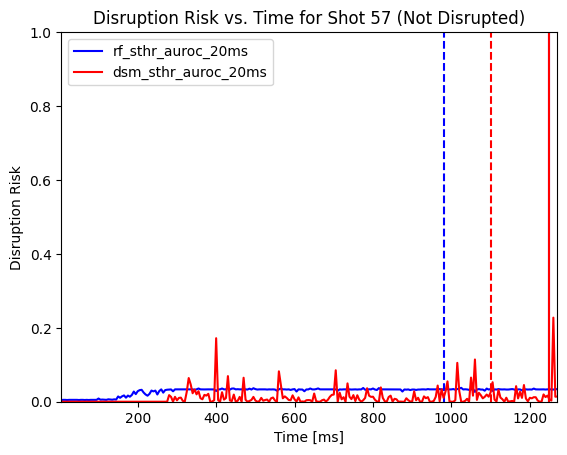

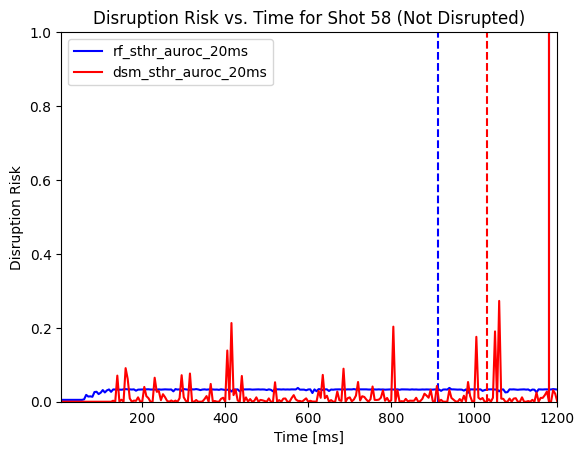

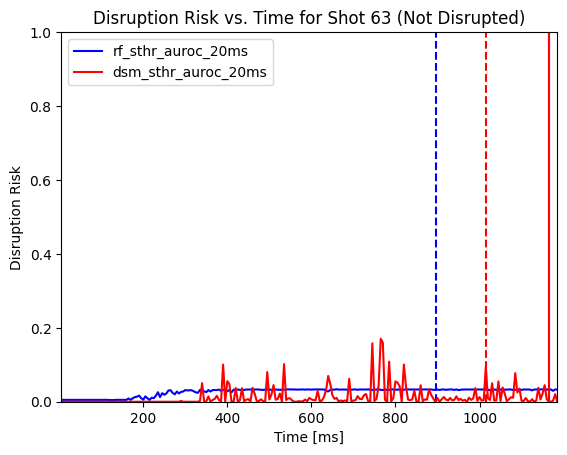

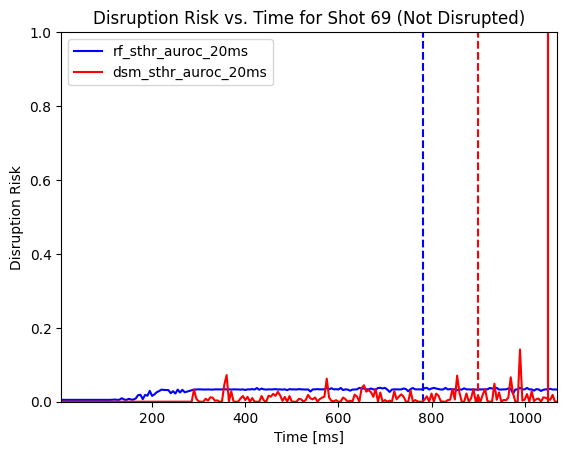

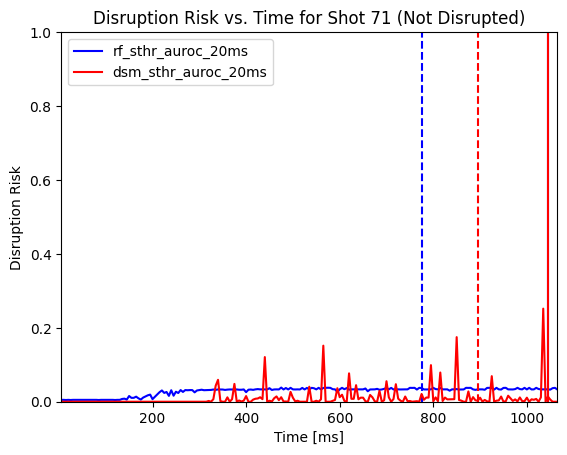

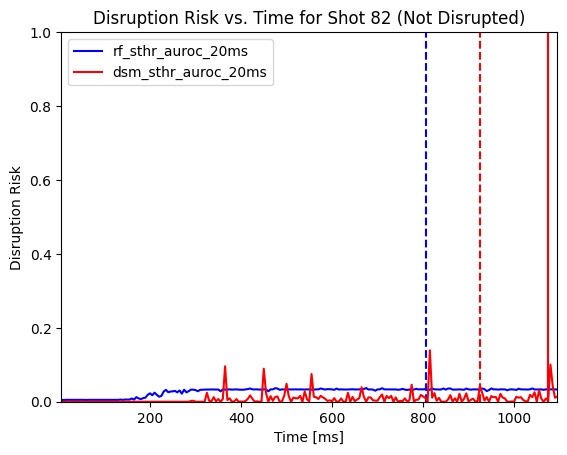

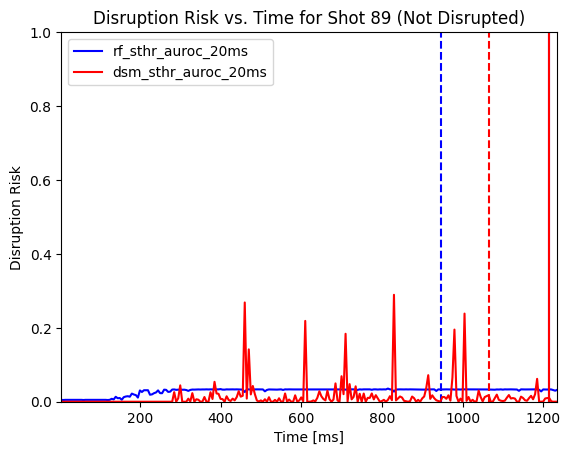

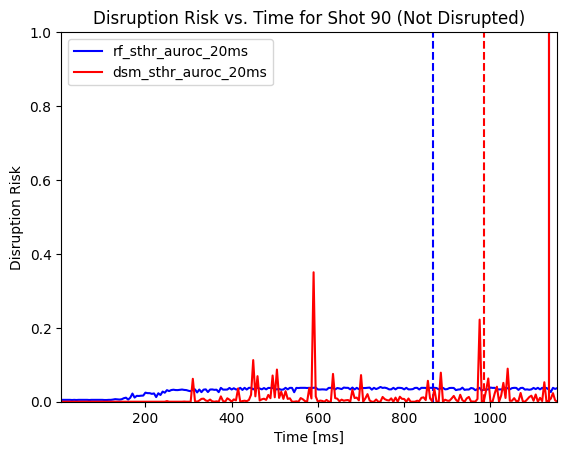

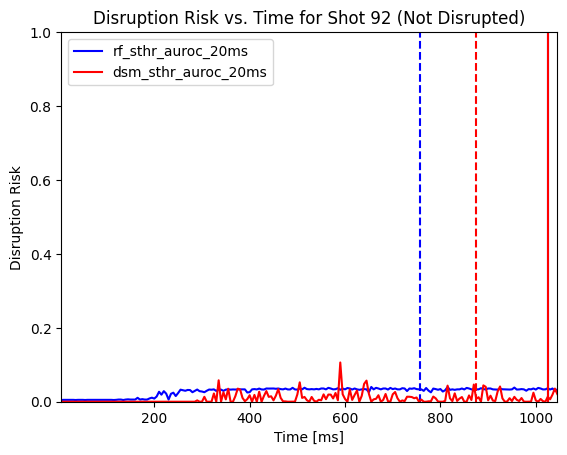

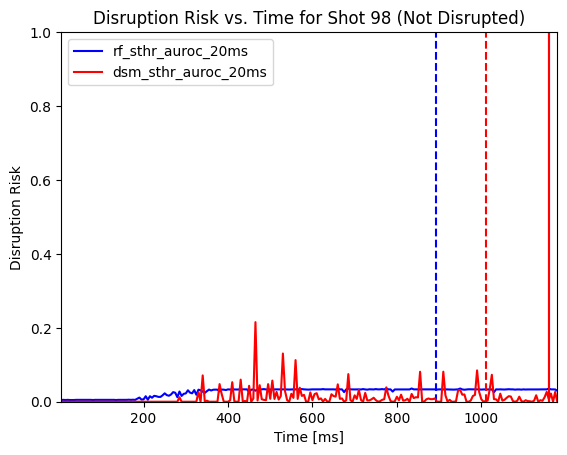

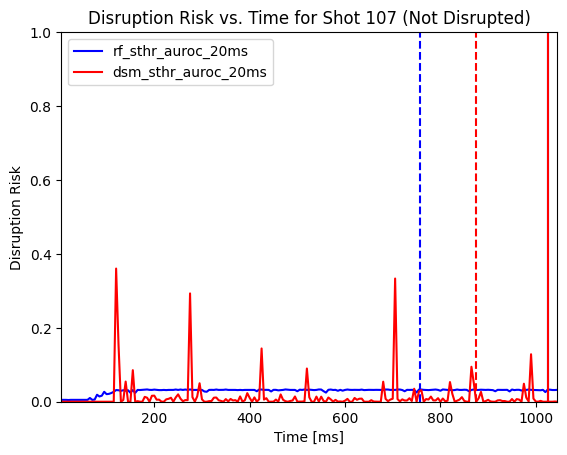

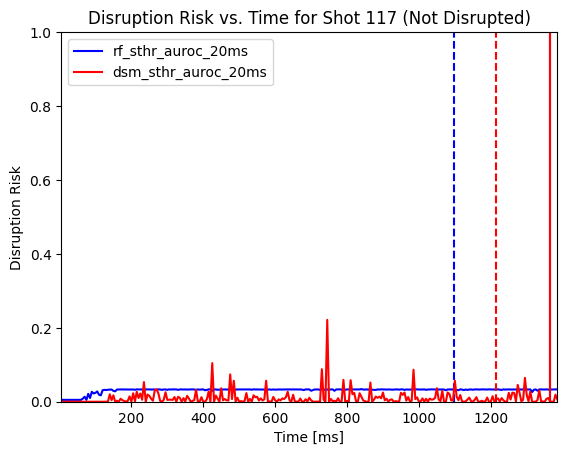

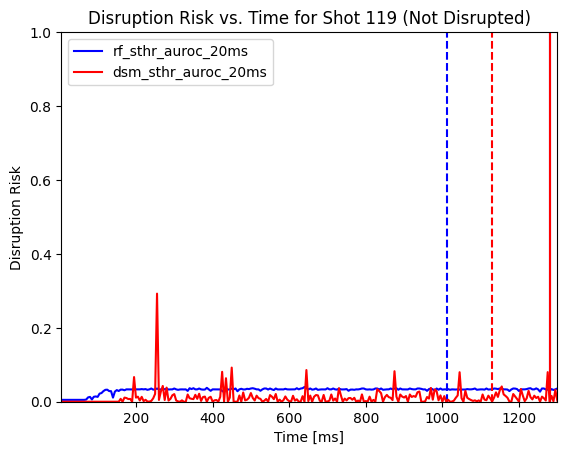

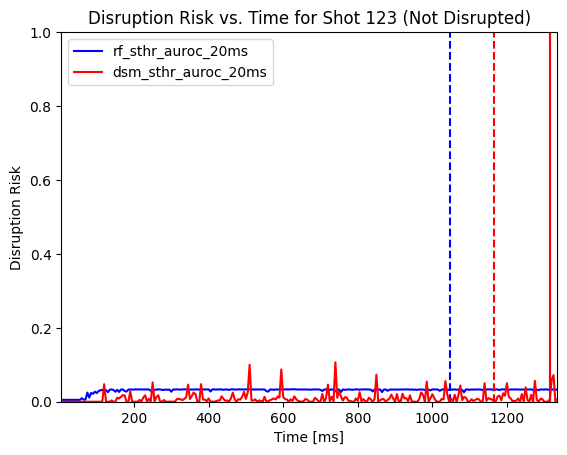

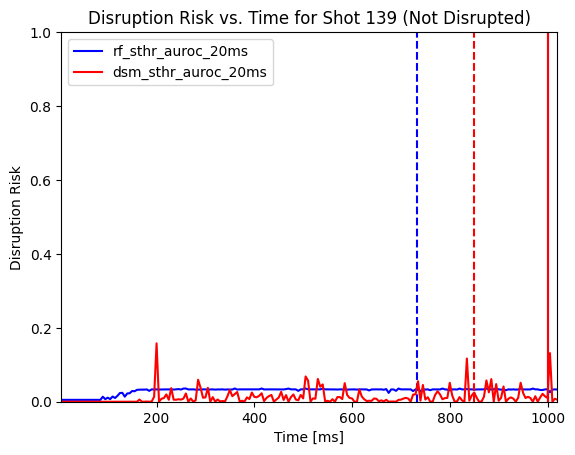

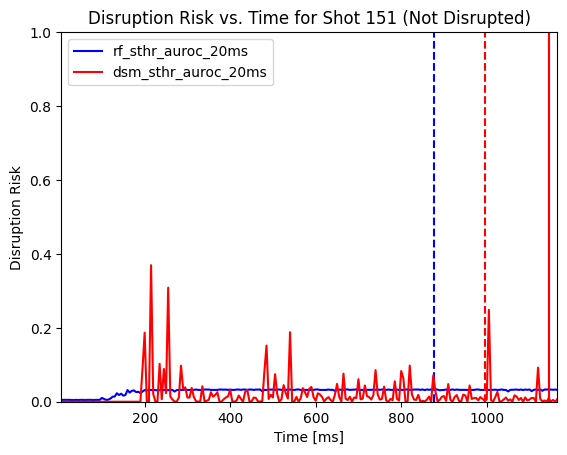

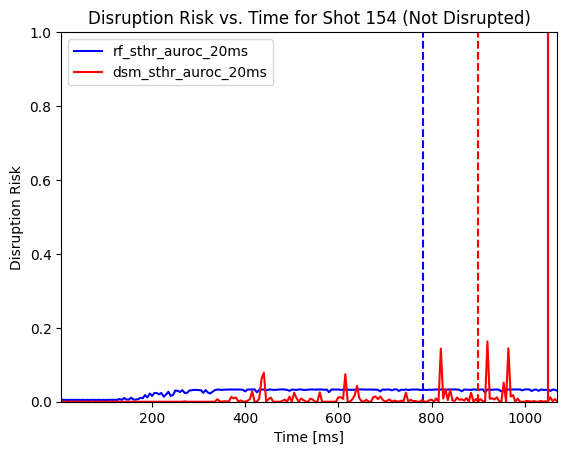

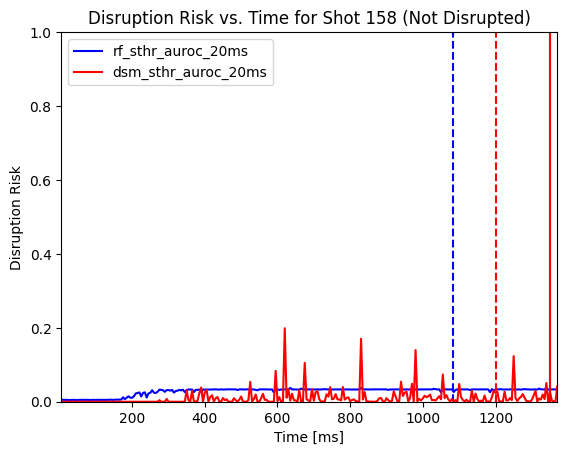

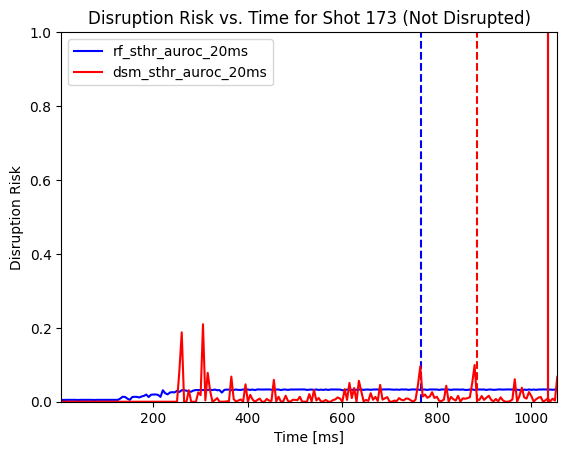

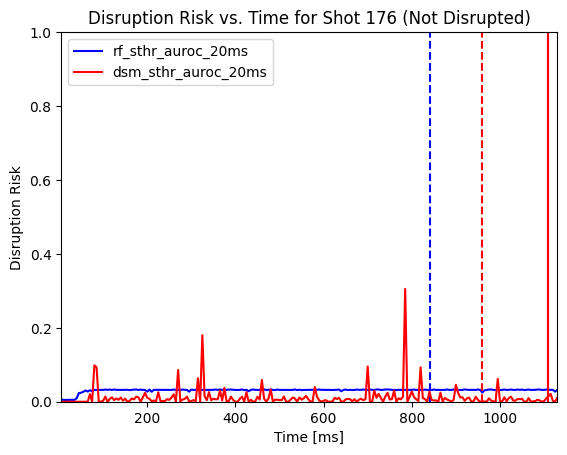

In [ ]:
for shot_number in experiment_list[0].get_disruptive_shot_list():
    plot_risk_compare_models(experiment_list, shot_number)
    #plot_ettd_compare_models(experiment_list, shot_number)

for shot_number in experiment_list[0].get_non_disruptive_shot_list():
    plot_risk_compare_models(experiment_list, shot_number)
    #plot_ettd_compare_models(experiment_list, shot_number)


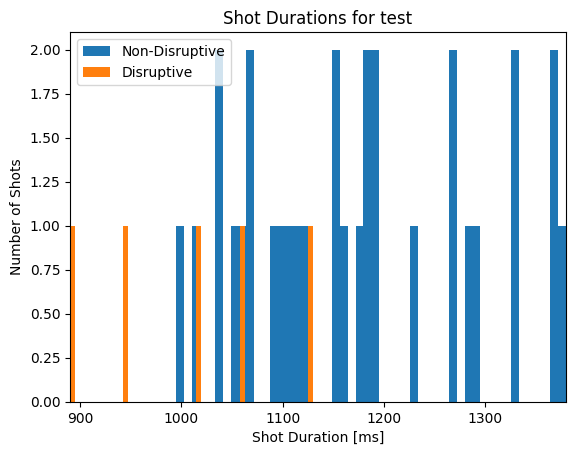

In [ ]:
plot_disruptive_vs_non_disruptive_shot_durations(experiment_list[0])